In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import multiprocessing
print(f'cpu count: {multiprocessing.cpu_count()}')
import numpy as np
import numpy.typing as npt
from tqdm import tqdm
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

cpu count: 128


In [12]:
def simulate_one(
    n: int, 
    eta_g: float, 
    n_batch: int, 
    frame: str,
    seed: int=0
) -> npt.NDArray[np.float64]:
    """Simulate one run of whitening algorithm with random cov and given frame."""
    assert frame in ["GRASSMANN", "RANDN", "SPECTRAL", "SPECTRAL_FRAME"]
    np.random.seed(seed)
    # setup
    k = n * (n + 1) // 2
    rng = np.random.default_rng(seed=seed)
    V, _ = np.linalg.qr(rng.standard_normal((n, n)))
    s = np.exp((np.linspace(-3, 3, n) + rng.standard_normal((n, )))*.1) 

    # Cxx = V @ np.diag(s) @ V.T
    Cxx =  np.diag(s)   # DIAGONAL COV

    if frame == "GRASSMANN":
        if k >3:
            W, _ = fw.get_grassmannian(n, k, rng) 
        else:
            W = fw.get_mercedes_frame()
    elif frame == "RANDN":
        W = rng.standard_normal((n, k))
    elif frame == "SPECTRAL_FRAME":
        W = np.concatenate([np.eye(n), rng.standard_normal((n, k-n))], 1)
    else:  # spectral
        W = np.eye(n)
    W = fw.normalize_frame(W)

    g_last, _, errors, _ = fws.adapt_covariance(
        [Cxx], W, 0, n_batch, eta_g, None, False, False, 1., verbose=False, break_on_convergence=False,
        )

    return errors, g_last

def simulate_many(
    n: int,
    n_steps: int,
    n_repeats: int, 
    lr: float,
    frame: str,
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel."""

    with multiprocessing.Pool() as pool:
        all_errors = []
        all_g = []
        pbar = tqdm(total=n_repeats)
        for output in pool.starmap(simulate_one, [(n, lr, n_steps, frame, i) for i in range(n_repeats)]):
            errors, g_last = output
            if len(errors) != n_steps:
                errors = errors + [errors[-1]] * (n_steps - len(errors))
            all_errors.append(errors)
            all_g.append(g_last[0])
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors, all_g

In [13]:
n_repeats = 100
n = 16
n_steps = 8096
lr = 5E-3
all_errors_randn,_ = simulate_many(n, n_steps, n_repeats, lr, "RANDN")
all_errors_grassmann,_ = simulate_many(n, n_steps, n_repeats, lr, "GRASSMANN")
all_errors_spectral_frame, g_last_spectral_frame = simulate_many(n, n_steps, n_repeats, lr, "SPECTRAL_FRAME")
all_errors_spectral, g_last_spectral = simulate_many(n, n_steps, n_repeats, lr, "SPECTRAL")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 68.91it/s]


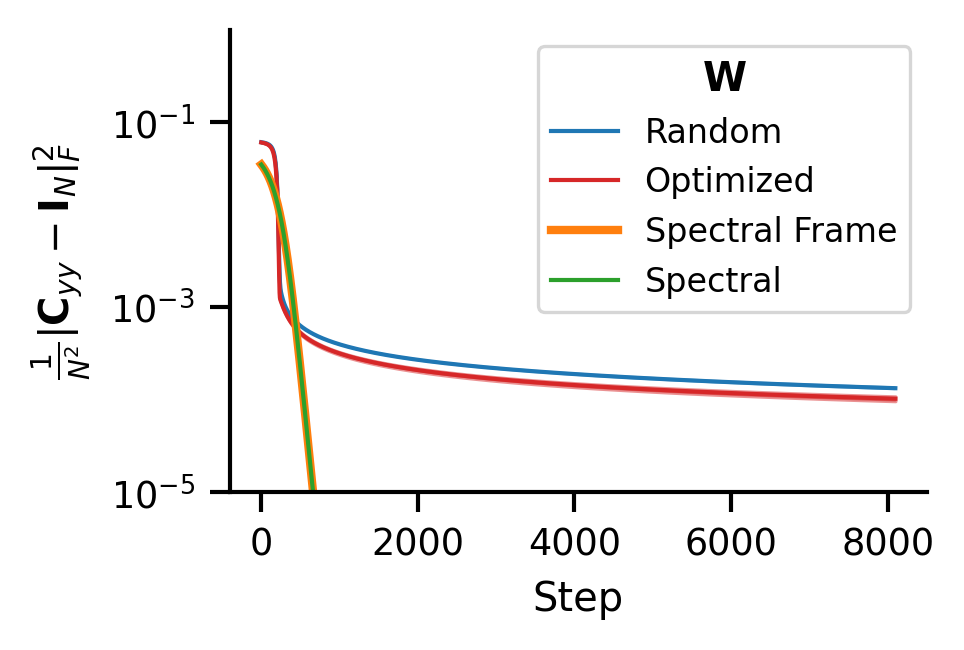

In [14]:
# fmt: off
def get_mean_sem(x):
    return np.mean(x, axis=0), np.std(x, axis=0) / np.sqrt(x.shape[0])

with sns.plotting_context("paper", font_scale=1):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2) ,dpi=300)

    mu_randn, sig_randn = get_mean_sem(all_errors_randn)
    mu_opt, sig_opt = get_mean_sem(all_errors_grassmann)
    mu_spectral, sig_spectral = get_mean_sem(all_errors_spectral)

    ax.plot(range(1, len(mu_randn)+1), mu_randn, color="C0", label="Random", linewidth=1)
    ax.fill_between(range(1, len(mu_randn)+1), mu_randn - sig_randn, mu_randn + sig_randn, alpha=0.5)

    ax.plot(range(1, len(mu_opt)+1), mu_opt, color="C3", label="Optimized", linewidth=1)
    ax.fill_between(range(1, len(mu_opt)+1), mu_opt - sig_opt, mu_opt + sig_opt, color="C3", alpha=0.5)

    ax.plot(range(1, len(mu_spectral)+1), mu_spectral, color="C1", label="Spectral Frame", linewidth=2)
    # ax.fill_between(range(1, len(mu_spectral)+1), mu_spectral - sig_spectral, mu_spectral + sig_spectral, color="C1", alpha=0.5)

    ax.plot(range(1, len(mu_spectral)+1), mu_spectral, color="C2", label="Spectral", linewidth=1)

    ax.set(yscale="log", 
    # xscale="log", 
    ylabel=r"$\frac{1}{N^2}\|{\bf C}_{yy} - {\bf I}_N\|_F^2$", 
    xlabel="Step", 
    # xticks=(1, 100_000), 
    ylim=(1E-5, 1E0))

    ax.legend(title=r"${\bf W}$", fontsize=8, loc="upper right")

    sns.despine()
# fmt: on

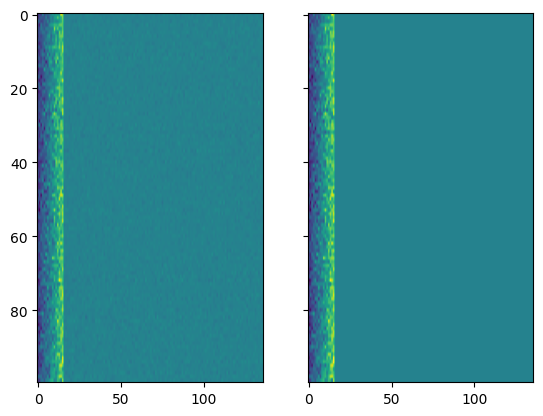

In [9]:
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')
vmin, vmax = np.min(g_last_spectral_frame), np.max(g_last_spectral_frame) 
ax[0].imshow(g_last_spectral_frame, aspect='auto', vmin=vmin, vmax=vmax)
ax[1].imshow(np.concatenate([g_last_spectral, np.zeros((100, 120))], 1), aspect='auto', vmin=vmin, vmax=vmax)

## context switching

In [26]:
N = 16
Kn = N * (N + 1) // 2

rng = np.random.default_rng(0)
# generate two contexts: two covariance matrices with eigenvectors V1 and V2

# V1, _ = np.linalg.qr(rng.standard_normal((N, N)))
V1 = np.eye(N)
V2, _ = np.linalg.qr(rng.standard_normal((N, N)))
# s = np.exp(rng.uniform(0, 4, N))
s = np.exp((np.linspace(-3, 3, N) + rng.standard_normal((N, )))*.1) 

C1 = V1 @ np.diag(s) @ V1.T
C2 = V2 @ np.diag(s) @ V2.T
# C2 = C1

W = np.concatenate([V1, V2, rng.standard_normal((N, Kn-(2*N)))], 1)
# W = np.concatenate([V1, rng.standard_normal((N, Kn-N))], 1)
W = fw.normalize_frame(W)
# W = V1

eta_g = 5E-3

n_batch = 20_000
g_last, _, errors, _ = fws.adapt_covariance(
    [C1, C2], W, 0, n_batch, eta_g, None, False, False, 1., verbose=True, break_on_convergence=False
    )


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:12<00:00, 3102.09it/s]


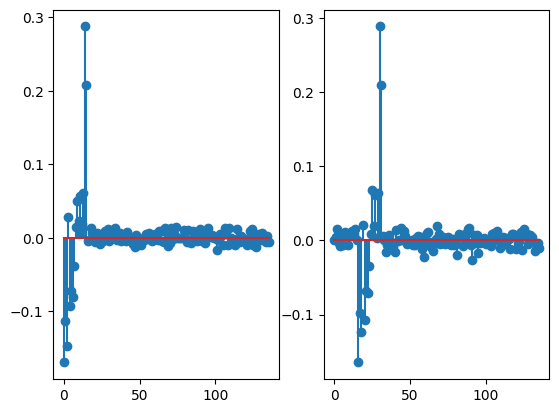

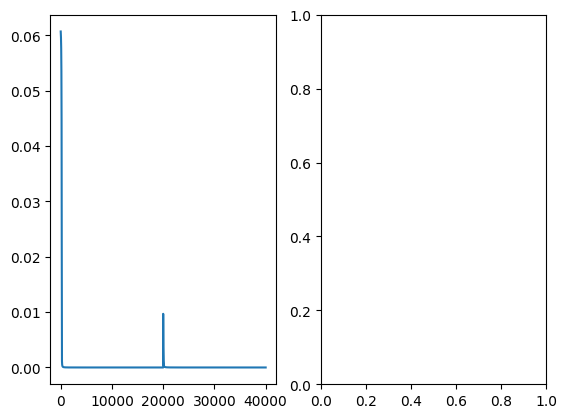

In [30]:
fig, ax = plt.subplots(1, 2)
# ax.plot(errors)
# ax.set(yscale='log')
ax[0].stem(g_last[0])
ax[1].stem(g_last[1])


fig, ax = plt.subplots(1, 2)
ax[0].plot(errors)